### Exploration of subtasks / methodology:

 - ### Caption sentiment class extraction
 - ### Caption sentiment classifier
 - ### Image feature extraction Pipeline: 
     - VGG-16
     - Inception
     - AlexNet
         - According to [google's dataset paper](https://www.aclweb.org/anthology/P18-1238.pdf) Inception_Resnet_v2 is best for feature extraction
 - ### Image object detection/ data
 - ### Object + Sentiment sentence generation
 - ### End to End model from tutorial
 - ### Caption evaluation pipeline:
     - BLEU score
     - Perplexity?
 

## Initial loading and displaying

In [149]:
import pandas as pd

In [144]:
sample_data_folder = r'data/10_k_cleaned_google'
meta_data_file = r'cleaned_filtered.csv'
images_folder = r'images_filtered'

In [145]:
image_captions = pd.read_csv(os.path.join(sample_data_folder,meta_data_file), index_col='index')
image_captions.rename(columns = {'0':'caption', '1':'link', '2':'objects', '3': 'mid', '4': 'object_confidence'}, inplace=True)
image_captions.head()


,caption,link,objects,mid,object_confidence,pos
index,,,,,,
0,snowman on a red background,https://thumb10.shutterstock.com/display_pic_w...,"snowman,cartoon,christmas eve,greeting card,sa...","/m/0152hh,/m/0215n,/m/014r1s,/m/03r8dh,/m/027g...","0.9607862830162048,0.9256524443626404,0.869515...",0
1,celebrity celebrates with his team mates after...,https://media.gettyimages.com/photos/david-bec...,"player,sports,tournament,sports equipment,team...","/m/02vzx9,/m/06ntj,/m/012sbd,/m/05y5lj,/m/03x0...","0.995377242565155,0.9889867305755615,0.9811984...",1
2,"action shot of basketball player , passing the...",https://onwisconsin.uwalumni.com/content/uploa...,"sports,team sport,ball game,player,sport venue...","/m/06ntj,/m/03x045,/m/020m7t,/m/02vzx9,/m/0bmg...","0.9889867305755615,0.9755526781082153,0.974188...",2
3,a sunny winter day by lake .,https://s-media-cache-ak0.pinimg.com/originals...,"sky,snow,winter,natural landscape,nature,blue,...","/m/01bqvp,/m/06_dn,/m/086mh,/m/03d28y3,/m/05h0...","0.9884884357452393,0.9849196076393127,0.983304...",3
4,"the extraordinary domed ceiling , with an arti...",https://i.pinimg.com/736x/7d/7a/bd/7d7abd23c2d...,"ceiling,chandelier,light fixture,lighting,arch...","/m/03gfsp,/m/02ws6z,/m/08jpwt,/m/019sc6,/m/03n...","0.9757712483406067,0.9078124165534973,0.849791...",4


In [202]:
len(image_captions)

9303

In [146]:
#Add notebook relative file_path to image 
image_captions['image_path'] = image_captions['pos'].apply(lambda p: os.path.join(sample_data_folder,images_folder, str(p) + ".png"))
image_captions


,caption,link,objects,mid,object_confidence,pos,image_path
index,,,,,,,
0,snowman on a red background,https://thumb10.shutterstock.com/display_pic_w...,"snowman,cartoon,christmas eve,greeting card,sa...","/m/0152hh,/m/0215n,/m/014r1s,/m/03r8dh,/m/027g...","0.9607862830162048,0.9256524443626404,0.869515...",0,data/10_k_cleaned_google\images_filtered\0.png
1,celebrity celebrates with his team mates after...,https://media.gettyimages.com/photos/david-bec...,"player,sports,tournament,sports equipment,team...","/m/02vzx9,/m/06ntj,/m/012sbd,/m/05y5lj,/m/03x0...","0.995377242565155,0.9889867305755615,0.9811984...",1,data/10_k_cleaned_google\images_filtered\1.png
2,"action shot of basketball player , passing the...",https://onwisconsin.uwalumni.com/content/uploa...,"sports,team sport,ball game,player,sport venue...","/m/06ntj,/m/03x045,/m/020m7t,/m/02vzx9,/m/0bmg...","0.9889867305755615,0.9755526781082153,0.974188...",2,data/10_k_cleaned_google\images_filtered\2.png
3,a sunny winter day by lake .,https://s-media-cache-ak0.pinimg.com/originals...,"sky,snow,winter,natural landscape,nature,blue,...","/m/01bqvp,/m/06_dn,/m/086mh,/m/03d28y3,/m/05h0...","0.9884884357452393,0.9849196076393127,0.983304...",3,data/10_k_cleaned_google\images_filtered\3.png
4,"the extraordinary domed ceiling , with an arti...",https://i.pinimg.com/736x/7d/7a/bd/7d7abd23c2d...,"ceiling,chandelier,light fixture,lighting,arch...","/m/03gfsp,/m/02ws6z,/m/08jpwt,/m/019sc6,/m/03n...","0.9757712483406067,0.9078124165534973,0.849791...",4,data/10_k_cleaned_google\images_filtered\4.png
...,...,...,...,...,...,...,...
9625,adapted work to the universe .,https://i.pinimg.com/736x/b6/85/d9/b685d9287f3...,"text,sky,font,astronomical object,universe,atm...","/m/07s6nbt,/m/01bqvp,/m/03gq5hm,/m/01d9ll,/m/0...","0.9626815915107727,0.9585431814193726,0.945139...",9625,data/10_k_cleaned_google\images_filtered\9625.png
9626,praying and folding hands over poetry book,https://media.istockphoto.com/photos/praying-a...,"white,black,hand,black-and-white,finger,monoch...","/m/083jv,/m/019sc,/m/0k65p,/m/01g6gs,/m/09cx8,...","0.9628557562828064,0.9571874141693115,0.937342...",9626,data/10_k_cleaned_google\images_filtered\9626.png
9627,cute hand drawn seamless pattern with circles ...,https://thumb7.shutterstock.com/display_pic_wi...,"text,circle,font,pattern,line,design,number,il...","/m/07s6nbt,/m/01vkl,/m/03gq5hm,/m/0hwky,/m/03s...","0.9523645639419556,0.9162501692771912,0.908029...",9627,data/10_k_cleaned_google\images_filtered\9627.png


In [147]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
#load a few sample images with captions
def display_samples(meta_df, num_samples=5, seed = 0):
    #sample num_sample rows from the dataframe
    samples = meta_df.sample(n=num_samples,random_state = 0)
    for idx,row in samples.iterrows():
        file_name = row['image_path']
        caption = row['caption']
        #get objects and confidence scores
        objects = row['objects'].split(',')
        confidences = row['object_confidence'].split(',')
        
        obj_conf = [str((obj,conf[0:4])) for obj,conf in zip(objects,confidences)]
        num_obj = len(obj_conf)
        obj_str = "\n".join(obj_conf)
        image = Image.open(file_name)
        fig = plt.figure(figsize=(10,(0.3*num_obj)))
        ax = fig.add_subplot(121)
        
                         
        plt.xticks([])
        plt.yticks([])
        ax.imshow(image) 
        ax.set_title(caption)
        ax = fig.add_subplot(122)
        ax.text(0.1, 0.5, obj_str, horizontalalignment='left',verticalalignment='center')
        plt.xticks([])
        plt.yticks([])
        plt.show()
        
        







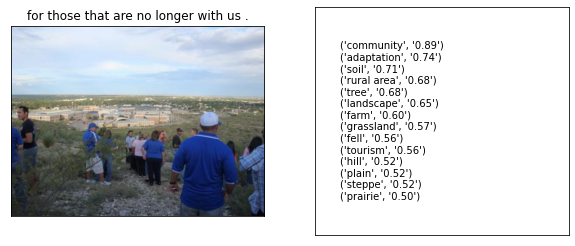

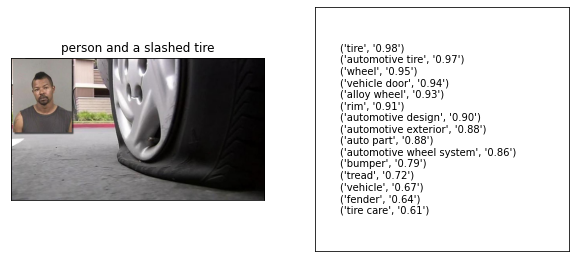

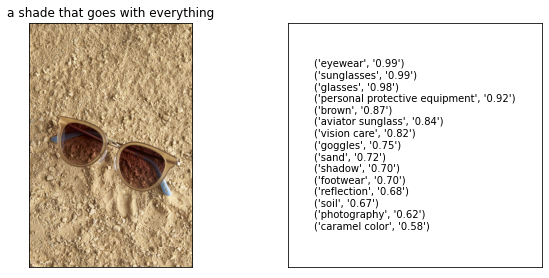

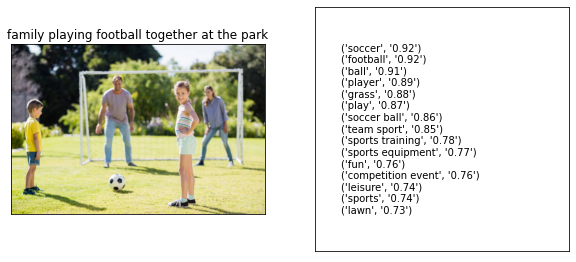

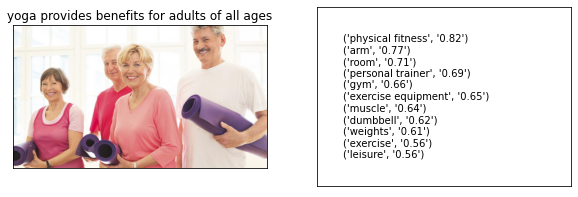

In [148]:
display_samples(image_captions)

## Profiling
- Size distribution of images
- Distribution of number of objects per image
- Distribution of number of objects at various confidence thresholds
- Distribution of caption size for each image

### Size distribution of images
This takes a while to run

In [151]:
image_captions['size'] = image_captions['image_path'].apply(lambda p: Image.open(p).size)
image_captions

,caption,link,objects,mid,object_confidence,pos,image_path,size
index,,,,,,,,
0,snowman on a red background,https://thumb10.shutterstock.com/display_pic_w...,"snowman,cartoon,christmas eve,greeting card,sa...","/m/0152hh,/m/0215n,/m/014r1s,/m/03r8dh,/m/027g...","0.9607862830162048,0.9256524443626404,0.869515...",0,data/10_k_cleaned_google\images_filtered\0.png,"(450, 470)"
1,celebrity celebrates with his team mates after...,https://media.gettyimages.com/photos/david-bec...,"player,sports,tournament,sports equipment,team...","/m/02vzx9,/m/06ntj,/m/012sbd,/m/05y5lj,/m/03x0...","0.995377242565155,0.9889867305755615,0.9811984...",1,data/10_k_cleaned_google\images_filtered\1.png,"(477, 612)"
2,"action shot of basketball player , passing the...",https://onwisconsin.uwalumni.com/content/uploa...,"sports,team sport,ball game,player,sport venue...","/m/06ntj,/m/03x045,/m/020m7t,/m/02vzx9,/m/0bmg...","0.9889867305755615,0.9755526781082153,0.974188...",2,data/10_k_cleaned_google\images_filtered\2.png,"(1200, 801)"
3,a sunny winter day by lake .,https://s-media-cache-ak0.pinimg.com/originals...,"sky,snow,winter,natural landscape,nature,blue,...","/m/01bqvp,/m/06_dn,/m/086mh,/m/03d28y3,/m/05h0...","0.9884884357452393,0.9849196076393127,0.983304...",3,data/10_k_cleaned_google\images_filtered\3.png,"(640, 640)"
4,"the extraordinary domed ceiling , with an arti...",https://i.pinimg.com/736x/7d/7a/bd/7d7abd23c2d...,"ceiling,chandelier,light fixture,lighting,arch...","/m/03gfsp,/m/02ws6z,/m/08jpwt,/m/019sc6,/m/03n...","0.9757712483406067,0.9078124165534973,0.849791...",4,data/10_k_cleaned_google\images_filtered\4.png,"(467, 700)"
...,...,...,...,...,...,...,...,...
9625,adapted work to the universe .,https://i.pinimg.com/736x/b6/85/d9/b685d9287f3...,"text,sky,font,astronomical object,universe,atm...","/m/07s6nbt,/m/01bqvp,/m/03gq5hm,/m/01d9ll,/m/0...","0.9626815915107727,0.9585431814193726,0.945139...",9625,data/10_k_cleaned_google\images_filtered\9625.png,"(500, 494)"
9626,praying and folding hands over poetry book,https://media.istockphoto.com/photos/praying-a...,"white,black,hand,black-and-white,finger,monoch...","/m/083jv,/m/019sc,/m/0k65p,/m/01g6gs,/m/09cx8,...","0.9628557562828064,0.9571874141693115,0.937342...",9626,data/10_k_cleaned_google\images_filtered\9626.png,"(612, 408)"
9627,cute hand drawn seamless pattern with circles ...,https://thumb7.shutterstock.com/display_pic_wi...,"text,circle,font,pattern,line,design,number,il...","/m/07s6nbt,/m/01vkl,/m/03gq5hm,/m/0hwky,/m/03s...","0.9523645639419556,0.9162501692771912,0.908029...",9627,data/10_k_cleaned_google\images_filtered\9627.png,"(450, 470)"


In [153]:
#number of different sizes:
image_captions['size'].describe()

count           9303
unique          3479
top       (450, 470)
freq             800
Name: size, dtype: object

In [159]:
#profiling widths and heights
image_captions['height'] = image_captions['size'].apply(lambda x: x[1])
image_captions['width'] = image_captions['size'].apply(lambda x: x[0])

In [160]:
image_captions['height'].describe()


count    9303.000000
mean      665.512953
std       332.147768
min       150.000000
25%       470.000000
50%       600.000000
75%       736.000000
max      5760.000000
Name: height, dtype: float64

In [161]:
image_captions['width'].describe()

count    9303.000000
mean      714.701709
std       366.482221
min       150.000000
25%       470.000000
50%       612.000000
75%       800.000000
max      5184.000000
Name: width, dtype: float64

<AxesSubplot:ylabel='Frequency'>

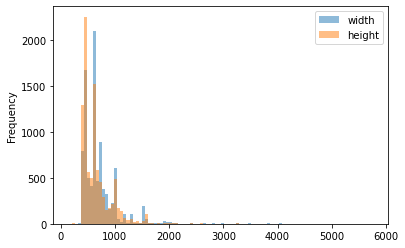

In [167]:
image_captions[['width','height']].plot.hist(bins=100, alpha=0.5)

In [ ]:
#looks like most images have a height and width under 1000 

In [183]:
quant = 0.99
print(image_captions['height'].quantile(quant))
print(image_captions['width'].quantile(quant))

1893.9399999999987
2048.0


### Number of objects per image

In [240]:
image_captions['num_obj'] = image_captions['objects'].apply(lambda o: 0 if pd.isna(o) else len(str(o).split(',')))

In [241]:
image_captions['num_obj'].describe()


count    9303.000000
mean       12.065678
std         3.626968
min         0.000000
25%         9.000000
50%        14.000000
75%        15.000000
max        15.000000
Name: num_obj, dtype: float64

In [242]:
image_captions['num_obj'].value_counts()


15    4489
12     534
11     519
10     499
9      493
13     452
14     447
8      442
7      437
6      346
5      271
4      181
3      124
2       47
1       18
0        4
Name: num_obj, dtype: int64

All but 4 images have atleast 1 object in them and a maximum of 15 objects in them and around 50% of the images have 15 objects detected

<AxesSubplot:ylabel='Frequency'>

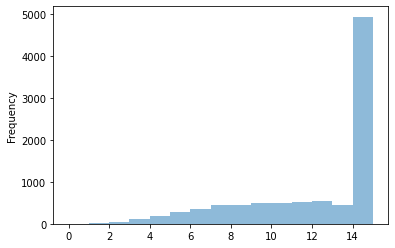

In [243]:
image_captions['num_obj'].plot.hist(bins=15, alpha=0.5)

### Distribution of num_objects at various confidence thresholds


In [303]:
def get_objects_with_conf_above(meta_df, threshold):
    """
    Returns a Series with a list of tuples (object,float) of object and confidence with confidence greater that threshold.
    """

    #object_conf tuple for objects with confidence above threshold
    obj_conf = image_captions.apply(lambda x: [] if (pd.isna(x.objects) or pd.isna(x.object_confidence))
                                   else [(obj,float(conf)) for (obj,conf) in zip(x.objects.split(','), x.object_confidence.split(',')) 
                                        if float(conf) >=threshold], axis=1)
    return obj_conf
    


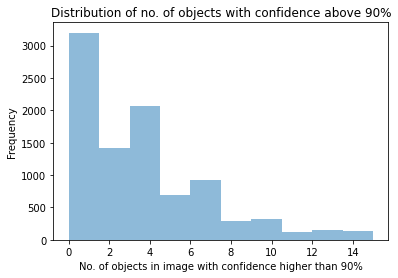

Number of images with atleast 1 caption with confidence higher than 90%: 7725


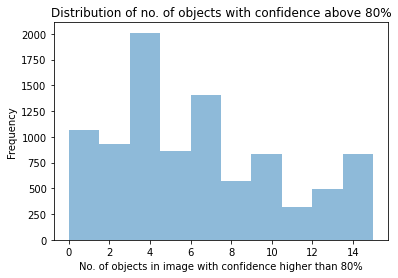

Number of images with atleast 1 caption with confidence higher than 80%: 8916


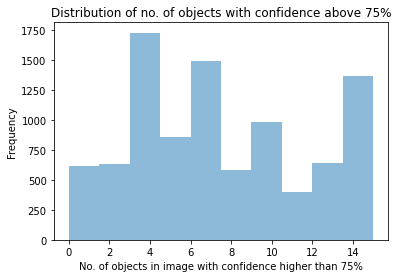

Number of images with atleast 1 caption with confidence higher than 75%: 9105


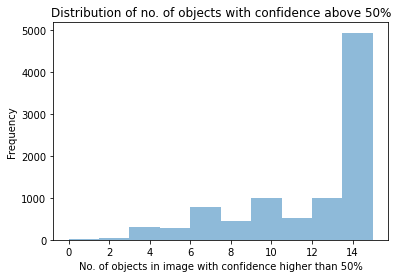

Number of images with atleast 1 caption with confidence higher than 50%: 9299


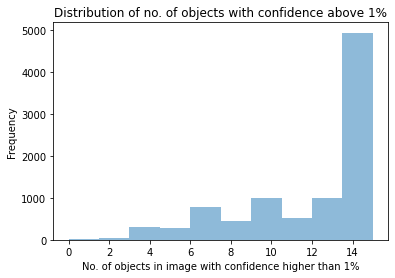

Number of images with atleast 1 caption with confidence higher than 1%: 9299


In [304]:
#get number of objects at various thresholds and plot them
thresholds = [90,80,75,50,1]
for t in thresholds:
    num_obj_conf = get_objects_with_conf_above(image_captions,(t*0.01)).apply(lambda l: len(l))
    num_obj_conf.plot.hist(alpha=0.5,title=f"Distribution of no. of objects with confidence above {t}%").set_xlabel(f"No. of objects in image with confidence higher than {t}%")
    plt.show()
    print(f"Number of images with atleast 1 caption with confidence higher than {t}%:",len(num_obj_conf[num_obj_conf > 0]))   



### Distribution of caption size


In [305]:
caption_size = image_captions['caption'].apply(lambda x: len(x.split(" ")))
caption_size.describe()



count    9303.000000
mean       10.318929
std         4.769947
min         5.000000
25%         7.000000
50%         9.000000
75%        12.000000
max        41.000000
Name: caption, dtype: float64

<AxesSubplot:title={'center':'Distribution of caption size of image captions'}, ylabel='Frequency'>

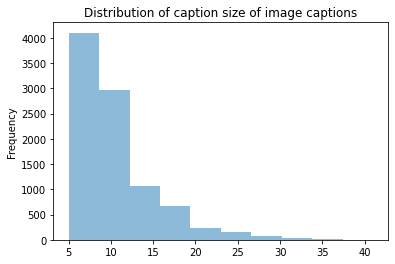

In [306]:
caption_size.plot.hist(alpha=0.5,title="Distribution of caption size of image captions")

In [307]:
caption_size.value_counts()

6     1164
7     1103
8     1077
9      876
10     817
5      758
11     690
12     583
13     447
14     344
15     275
16     215
17     181
18     172
19     104
20      93
21      75
22      61
23      58
24      46
25      35
27      21
28      20
30      19
26      17
29      12
31      11
32       9
33       7
34       4
38       3
35       3
36       2
41       1
Name: caption, dtype: int64

In [308]:
caption_size.quantile(0.9)

17.0

In [309]:
caption_size.quantile(0.99)



27.0